# Signpost CNN Classification

In this kernel I’ll try to identify correctly which signpost we are seeing ( 43 types of signposts).
In order to do so I’ll use signpost image dataset as input to a CNN (since we have huge data set - no need for data augmentation  ) .
After optimzation process - optimal layers are 2 + 2 FC layers.
I also run semi grid search on dropout , filter size etc..

# Import

In [1]:
import numpy as np 
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
from math import sqrt, ceil
from timeit import default_timer as timer
import os

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler




Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

#  Show input files 

In [2]:
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/traffic-signs-preprocessed/data0.pickle
../input/traffic-signs-preprocessed/mean_image_rgb.pickle
../input/traffic-signs-preprocessed/std_gray.pickle
../input/traffic-signs-preprocessed/std_rgb.pickle
../input/traffic-signs-preprocessed/labels.pickle
../input/traffic-signs-preprocessed/data8.pickle
../input/traffic-signs-preprocessed/datasets_preparing.py
../input/traffic-signs-preprocessed/train.pickle
../input/traffic-signs-preprocessed/label_names.csv
../input/traffic-signs-preprocessed/mean_image_gray.pickle
../input/traffic-signs-preprocessed/data2.pickle
../input/traffic-signs-preprocessed/data5.pickle
../input/traffic-signs-preprocessed/data6.pickle
../input/traffic-signs-preprocessed/data1.pickle
../input/traffic-signs-preprocessed/data7.pickle
../input/traffic-signs-preprocessed/valid.pickle
../input/traffic-signs-preprocessed/test.pickle
../input/traffic-signs-preprocessed/data3.pickle
../input/traffic-signs-preprocessed/data4.pickle


# Make sure we have enough samples per signpost(43 types) 

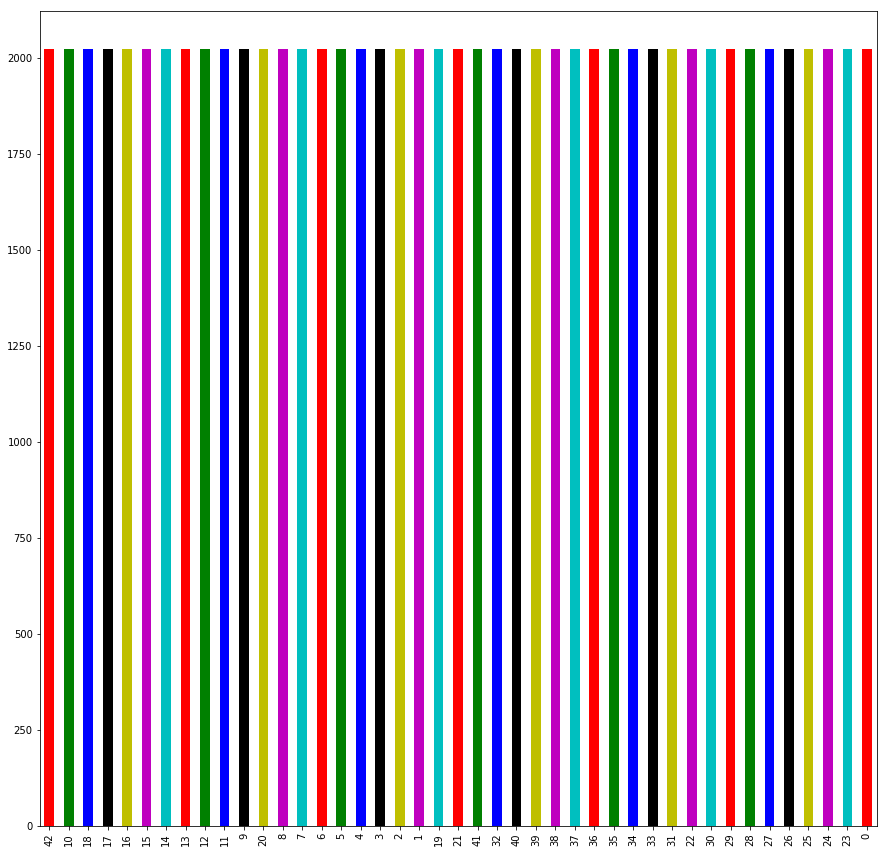

In [3]:
with open('../input/traffic-signs-preprocessed/data1.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type
pd_check=pd.DataFrame({'y_train': data['y_train']})
pd_check2=pd_check.sort_values(by=['y_train'],ascending=True)
pd_check=pd_check2.set_index(np.arange(len(pd_check2.index)))
#pd_check.reset_index(drop=True, col_level=0)
pd_check['y_train'].value_counts().plot(kind='bar',figsize=(15, 15),color=list('rgbkymc')) 

# Load one of the data set :
* Open file
* Make y(train & val) as categorical list
* Reshape X (test,val & test) to assure RGB image channels (3) comes last

In [4]:

data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

print("x_train_pre_shape" + ":" ,data['x_train'].shape )
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)






x_train_pre_shape: (86989, 3, 32, 32)


# Show dataset size  

In [5]:

for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

       

x_train: (86989, 32, 32, 3)
y_test: (12630,)
x_test: (12630, 32, 32, 3)
x_validation: (4410, 32, 32, 3)
labels: 43
y_train: (86989, 43)
y_validation: (4410, 43)


# Showing some examples

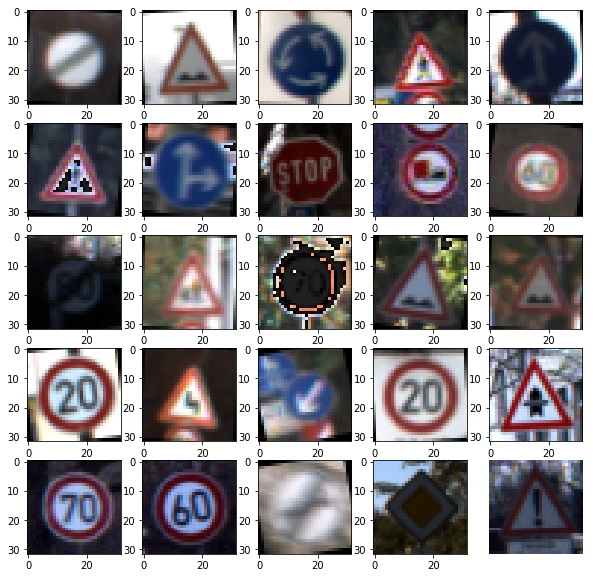

In [6]:

import random
matrix_hw=5
start_idx=random.randint(0,len(data['x_train'])-matrix_hw)

examples = data['x_train'][start_idx:start_idx+matrix_hw**2, :, :, :]
#print(examples.shape)  # (81, 32, 32, 3)
_, axs = plt.subplots(matrix_hw, matrix_hw) #n_row, n_col, figsize=(32, 32,3)
axs = axs.flatten()
for img, ax in zip(examples, axs):
    #print(mg)
    low, high = np.min(img), np.max(img)
    img = 255.0 * (img - low) / (high - low)
    ax.imshow(img.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
#plt.title('Some examples of training data', fontsize=18)
plt.show()

# Define CNN parameters

In [7]:
IMAGE_WIDTH    =32
IMAGE_HEIGHT   =32
IMAGE_SIZE     =(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS =3
DROP_OUT_VALUE =[0,0.1,0.2,0,0.1]
POOL_SIZE      =[2,2,2,3,3]
epochs         = 5
batch_size      =5
filters        = [3,3,3,3,3]

# Define CNN model

In [8]:

model = [0] * len(filters)

for i in range(len(model)):
    model[i] = Sequential()
    model[i].add(Conv2D(32, kernel_size=filters[i], activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    model[i].add(BatchNormalization())
    model[i].add(MaxPool2D(pool_size=(POOL_SIZE[i],POOL_SIZE[i])))
    model[i].add(Dropout(DROP_OUT_VALUE[i]))
    
    model[i].add(Conv2D(64, kernel_size=filters[i], activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(MaxPool2D(pool_size=(POOL_SIZE[i],POOL_SIZE[i])))
    model[i].add(Dropout(DROP_OUT_VALUE[i]))
    
    model[i].add(Flatten())
    model[i].add(Dense(512, activation='relu'))
    model[i].add(Dense(43, activation='softmax'))
    model[i].compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    model[i].summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

# Early Stop

To prevent over fitting we will stop the learning after 5 epochs and val_loss value not decreased (1% defualt)

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=5)


# Learning Rate Reduction

We will reduce the learning rate with some function

In [10]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))


# Training Models


In [11]:

h = [0] * len(model)

for i in range(len(h)):
    h[i] = model[i].fit(data['x_train'], data['y_train'],
                        batch_size=batch_size, epochs = epochs,
                        validation_data = (data['x_validation'], data['y_validation']),
                        callbacks=[annealer,earlystop], verbose=1)
    
    print('Model with filters {0:d}x{0:d},dropout {1:.2f},pooling size {2:d}x{2:d} epochs={3:d}, training acc={4:.5f}, val acc={5:.5f}'.\
      format(filters[i],DROP_OUT_VALUE[i],POOL_SIZE[i], epochs, max(h[i].history['acc']), max(h[i].history['val_acc'])))


Train on 86989 samples, validate on 4410 samples
Epoch 1/5
86989/86989 [==============================] - 136s 2ms/step - loss: 0.4187 - acc: 0.9285 - val_loss: 0.4884 - val_acc: 0.9379
Epoch 2/5
86989/86989 [==============================] - 126s 1ms/step - loss: 0.1465 - acc: 0.9817 - val_loss: 0.3609 - val_acc: 0.9574
Epoch 3/5
86989/86989 [==============================] - 129s 1ms/step - loss: 0.0855 - acc: 0.9902 - val_loss: 0.3421 - val_acc: 0.9630
Epoch 4/5
86989/86989 [==============================] - 132s 2ms/step - loss: 0.0626 - acc: 0.9931 - val_loss: 0.3954 - val_acc: 0.9635
Epoch 5/5
35085/86989 [===========>..................] - ETA: 1:18 - loss: 0.0427 - acc: 0.9958

# Plotting accuracy per model

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


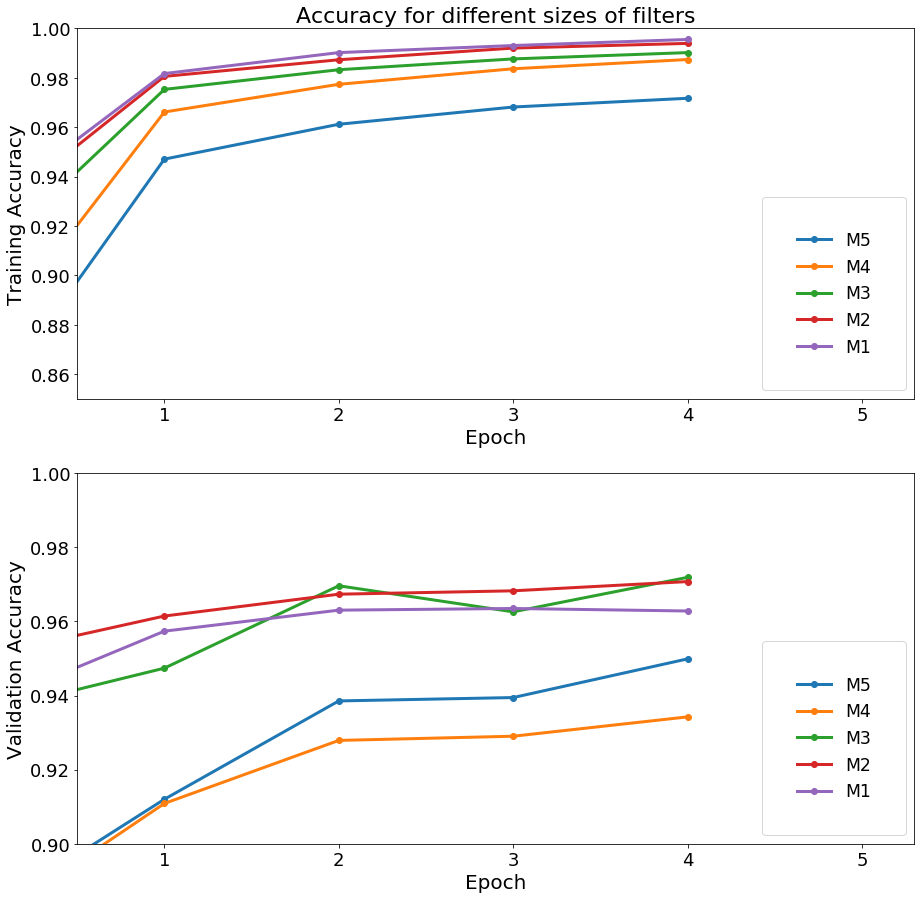

In [12]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 15.0) 
plt.rcParams['image.interpolation'] = 'nearest'

fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(h[4].history['acc'], '-o', linewidth=3.0)
plt.plot(h[3].history['acc'], '-o', linewidth=3.0)
plt.plot(h[2].history['acc'], '-o', linewidth=3.0)
plt.plot(h[1].history['acc'], '-o', linewidth=3.0)
plt.plot(h[0].history['acc'], '-o', linewidth=3.0)
plt.legend(['M5', 'M4', 'M3', 'M2', 'M1'], loc='lower right', fontsize='xx-large', borderpad=2)
plt.xlabel('Epoch', fontsize=20, fontname='Times New Roman')
plt.ylabel('Training Accuracy', fontsize=20, fontname='Times New Roman')
plt.yscale('linear')  # {"linear", "log", "symlog", "logit", ...}
plt.ylim(0.85, 1.0)
plt.xlim(0.5, 5.3) 
plt.title('Accuracy for different sizes of filters', fontsize=22)
plt.tick_params(labelsize=18)

plt.subplot(2, 1, 2)
# plt.gca().set_title('Validation accuracy')

plt.plot(h[4].history['val_acc'], '-o', linewidth=3.0)
plt.plot(h[3].history['val_acc'], '-o', linewidth=3.0)
plt.plot(h[2].history['val_acc'], '-o', linewidth=3.0)
plt.plot(h[1].history['val_acc'], '-o', linewidth=3.0)
plt.plot(h[0].history['val_acc'], '-o', linewidth=3.0)
plt.legend(['M5', 'M4', 'M3', 'M2', 'M1'], loc='lower right', fontsize='xx-large', borderpad=2)
plt.xlabel('Epoch', fontsize=20, fontname='Times New Roman')
plt.ylabel('Validation Accuracy', fontsize=20, fontname='Times New Roman')
plt.yscale('linear')  # {"linear", "log", "symlog", "logit", ...}
plt.ylim(0.9, 1)
plt.xlim(0.5, 5.3)
plt.tick_params(labelsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('models_acc_cmp.png')
plt.close()




# Predict Xtest 

In [13]:
for i in range(len(model)):
    temp = model[i].predict(data['x_test'])
    temp = np.argmax(temp, axis=1)
    temp = np.mean(temp == data['y_test'])
    
    print('data2 filter {0:d} testing accuracy = {1:.5f}'.format(filters[i], temp))


data2 filter 3 testing accuracy = 0.94418
data2 filter 3 testing accuracy = 0.95218
data2 filter 3 testing accuracy = 0.94885
data2 filter 3 testing accuracy = 0.91077
data2 filter 3 testing accuracy = 0.92043


# Show example for prediction 

(1, 32, 32, 3)
[3]


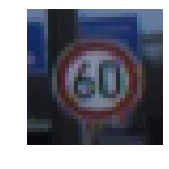

(43,)
ClassId: 3
Label: Speed limit (60km/h)


In [14]:
%matplotlib inline

# Preparing image for predicting from test dataset
x_input = data['x_test'][100:101]
print(x_input.shape)
y_input = data['y_test'][100:101]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

# Showing the plot
plt.show()

# Getting scores from forward pass of input image
scores = model[0].predict(x_input)
print(scores[0].shape) # (43,)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)

# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list


# Getting labels
labels = label_text('../input/traffic-signs-preprocessed/label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])


# Save Models

In [15]:
for i in range(len(model)):
    name = 'model-' + str(filters[i]) + 'x' + str(filters[i]) + '.h5'
    model[i].save(name)


